### Import Libraries

In [1]:
from requests_html import HTMLSession
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import re
import math

### Fuctions to extract info from CORE webpage

In [2]:
# this function for the getting information from the web page

def get_paperinfo(paper_url):

    #download the page
    session = HTMLSession()
    response=session.get(paper_url)

  # check successful response
    if response.status_code != 200:
        print('Status code:', response.status_code)
        raise Exception('Failed to fetch web page ')

  #parse using beautiful soup
    paper_doc = BeautifulSoup(response.text,'html.parser')

    return paper_doc



def core_attributes(doc):
    
    '''
    recieves a doc file from the get_paperinfo function
    and returns title, ref and abstract from the CORE webpage
    '''
    
    # text contains title and references
    text = doc.main.find_all('h3')
    # ab contains the abstracts
    ab = doc.find_all("div", itemprop="abstract")
    
    papers = []
  
    for i, (t,a) in enumerate(zip(text,ab)):
        title = t.get_text()
        ref = t.a.get('href')
        abstract = a.get_text()
        
        # check if the article does not have an abstract
        if abstract == '':
            print(f'Article{i}: {title} has an empty abstract')
        
        # else append to a list
        else:
            papers.append([title, ref, abstract])

    return papers


### Generation of pandas df with stored paper data

In [5]:
# Getting information from CORE
gene = 'rab11a'
doc = get_paperinfo(f'https://core.ac.uk/search?q={gene}+AND+language%3A"en"&page=1')
n_output = doc.find("div", class_="styles_header__dGlUR").p.get_text()
#n_output = n_output.p.get_text()
number = re.findall('[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?', n_output)
number = float(number[0].replace(',', ''))
round_ = math.ceil(number/10)

#Create empty dataframe
df = pd.DataFrame(columns = ['title', 'ref', 'abstract'])

#Iterate over different pages on the CORE database to obtain titlt, ref and abstract and add to df
for l in tqdm(range(1,round_)):
    doc = get_paperinfo(f'https://core.ac.uk/search?q={gene}+AND+language%3A%22en%22&page={l}')
    papers = core_attributes(doc)
    dft = pd.DataFrame(papers, columns = ['title', 'ref', 'abstract'])
    df = pd.concat([df,dft])  
    
df.shape

  0%|          | 0/66 [00:00<?, ?it/s]

Article5: Cdk5 Regulation of the GRAB-Mediated Rab8-Rab11 Cascade in Axon Outgrowth has an empty abstract
Article2: Mechanisms of pronuclear migration in mammalian zygotes has an empty abstract
Article5: Two mechanisms drive pronuclear migration in mouse zygotes has an empty abstract
Article9: Microvillus Inclusion Disease. Lessons about the apical plasma membrane. has an empty abstract
Article1: Oncogene-induced endocytic trafficking in cell migration and invasion has an empty abstract
Article3: Recycling endosomes has an empty abstract
Article8: Dynamic regulation of the subunit composition of BK channels in smooth muscle has an empty abstract
Article1: Pathogenic mechanisms in microvillus inclusion disease has an empty abstract
Article3: Actin organization at intracellular membranes: Targeting and regulatory interations of the spir/formin actin nucleator complex has an empty abstract
Article8: Comprehensive knockout analysis of the Rab family GTPases in epithelial cells has an empty

Article2: Molecular Machinery Regulating Exocytosis has an empty abstract
Article4: Cell wall rhamnosylation: an original target for innovative antimicrobial strategies against Listeria monocytogenes has an empty abstract
Article9: Norepinephrine induces internalization of Kv1.1 in hippocampal neurons has an empty abstract
Article3: Studies on the mechanisms of maturation and membrane disassembly of vacuoles containing invasive bacteria has an empty abstract
Article5: Investigating the role of miR-21 in adult neurogenesis has an empty abstract
Article8: Differentiation of early and late human hematopoietic progenitor cells into dendritic cells in vitro has an empty abstract
Article6: Atg21 restricts Atg8 lipidation to a novel vacuole-phagophore contact site has an empty abstract
Article0: Myosin Function During Cytokinesis in the C. elegans One-cell Embryo has an empty abstract
Article1: HTRA1 loss-of-function signatures in the brain vessel proteomes of CADASIL and cerebral amyloid ang

KeyboardInterrupt: 

In [6]:
df

,title,ref,abstract
0,Enhancement of homology-directed repair with c...,https://core.ac.uk/works/85869333,A key challenge in precise genome editing is t...
1,Biogenesis of the inner membrane complex is de...,https://core.ac.uk/works/270485,Apicomplexan parasites belong to a recently re...
2,Reprogramming human T cell function and specif...,https://core.ac.uk/works/85857860,Decades of work have aimed to genetically repr...
3,A statistical analysis of particle trajectorie...,https://core.ac.uk/works/43119850,Recent advances in molecular biology and fluor...
4,Complex polarity: building multicellular tissu...,https://core.ac.uk/works/26535902,The formation of distinct subdomains of the ce...
...,...,...,...
0,A transcriptomic approach for studying the act...,https://core.ac.uk/works/537996,Mycobacterium tuberculosis (M. tuberculosis) i...
1,Sex-based differences in microbiota compositio...,https://core.ac.uk/works/120155888,Systemic lupus erythematosus (SLE) is a comple...
2,Effects of the pseudorabies virus US3 protein ...,https://core.ac.uk/works/31279484,US3 is a serine/threonine kinase conserved thr...
3,Endolysosomal Dysfunction in Parkinson Disease...,https://core.ac.uk/works/37685498,"Parkinson disease (PD) is a common, debilitati..."


#### Here comes the difficult part..... how to extract info from the abstracts..
One way to do it is to tokenize the texts

In [7]:
# Create a processes list from the Sheet2 of the secRecon dataset
processes_df = pd.read_csv('processes_list.csv')

processes = []
for p in processes_df[';Process Term']:
    p = p.lower()
    p = p.replace(';', '')
    processes.append(p)

print(processes)

['acetylation', 'acetyltransferase', 'additional', 'apoptosis', 'association with machinery', 'atf6 pathway', 'autophagosome formation', 'autophagy', 'carboxylase', 'carboxylation', 'cell and nuclear shrinkage', 'chondroitin sulfate', 'clathrin', 'co-translational translocation', 'coat', 'copi', 'copii', 'deacetylase', 'decarboxylase', 'direction', 'disulfide bond formation', 'endocytosis', 'endosome', 'energy-dependent translocation', 'er calcium homeostasis', 'er stress response/upr', 'er to golgi', 'erad', 'execution pathway', 'exocytosis', 'extrinsic pathway', 'function', 'ganglio series', 'globo series', 'glycosaminoglycan', 'glycosylation', 'golgi to er (retrograde)', 'gpi-anchor', 'gt ambiguous', 'heparan sulfate', 'hyaluronic acid', 'hydroxylysine', 'identificaton/targeting', 'intrinsic pathway', 'ire1 pathway', 'keratan sulfate', 'kinase', 'lacto/neolacto series', 'lipidation', 'lysosome', 'membrane fusion', 'multimerization', 'n-glycan', 'nucleotide-sugar transporter', 'o-gly

In [8]:
# Find how many abstracts in the entire dataset contains the specific process 
from nltk.tokenize import word_tokenize

relativities = []

for process in processes:
    count = 0
    for txt in df['abstract']:
        text = txt
        tokens = word_tokenize(text)
        if process in tokens:
            count += 1
        else:
            continue

    percentage = count/len(df['abstract'])*100
    relativities.append(percentage)

print(relativities)

[0.19047619047619047, 0.0, 4.380952380952381, 4.761904761904762, 0.0, 0.0, 0.0, 4.380952380952381, 0.19047619047619047, 0.0, 0.0, 0.0, 1.9047619047619049, 0.0, 0.7619047619047619, 0.0, 0.0, 0.38095238095238093, 0.0, 0.9523809523809524, 0.0, 7.0476190476190474, 6.857142857142858, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.190476190476191, 0.0, 28.19047619047619, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.666666666666668, 0.0, 0.19047619047619047, 2.4761904761904763, 0.0, 0.19047619047619047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.666666666666664, 2.666666666666667, 0.0, 0.0, 1.9047619047619049, 5.333333333333334, 0.0, 0.0, 0.0, 0.0, 0.7619047619047619, 0.0, 0.0, 0.0, 0.19047619047619047, 0.0, 0.0, 2.4761904761904763, 1.1428571428571428, 0.0, 0.0, 0.0, 0.19047619047619047]


In [9]:
import matplotlib.pyplot as plt
import numpy as np
d = {'Process':processes,'Rel':relativities}
rel_df = pd.DataFrame(d, columns=['Process','Rel'])
rel_df = rel_df.replace(0, np.nan)
rel_df = rel_df.dropna(how='any', axis=0)
rel_df = rel_df.replace(np.nan, 0)
rel_df = rel_df.sort_values('Rel', ascending=False)
rel_df

,Process,Rel
31,function,28.190476
58,other,22.666667
46,kinase,10.666667
21,endocytosis,7.047619
22,endosome,6.857143
63,phosphorylation,5.333333
3,apoptosis,4.761905
7,autophagy,4.380952
2,additional,4.380952
29,exocytosis,4.190476


/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_3485/3243372874.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


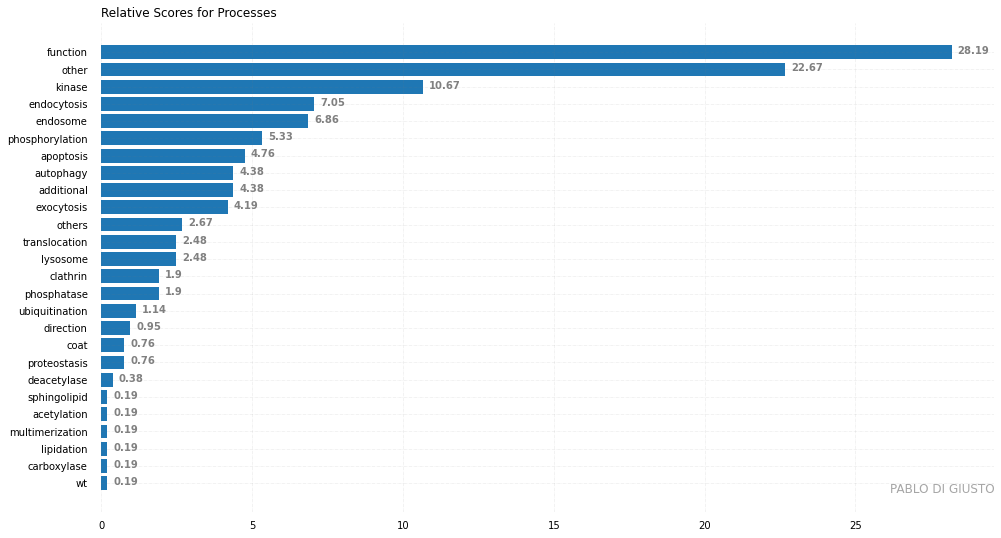

In [10]:
#PLOT

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(rel_df['Process'], rel_df['Rel'])
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title(f'{gene}-Relative Scores for Processes',
             loc ='left', )
 
# Add Text watermark
fig.text(0.9, 0.15, 'PABLO DI GIUSTO', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
#processes = ['lysosome', 'endocytosis', 'secretion', 'lipidation', 'kinase', 'glycosilation', 'heparan sulfate']

abstract_list = []
for txt in df['abstract']:
    text = txt
    tokens = word_tokenize(text)
    stemmed = []
    for token in tokens:
        stemmed_word = ps.stem(token)
        stemmed.append(stemmed_word)
    abstract_list.append(stemmed)
print(abstract_list[0])

In [ ]:
new_abstract_list = [' '.join(abstract) for abstract in abstract_list]
print(new_abstract_list[0])

In [ ]:
print(abstract_list)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize
cv = CountVectorizer(max_features=100,stop_words='english') 
cv_matrix = cv.fit_transform(new_abstract_list) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), index=df['title'].values, columns=cv.get_feature_names_out())
df_dtm

In [ ]:
df_dtm['will'].sum()